In [2]:
import warnings
warnings.filterwarnings('ignore')

# Packages

In [34]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import f_oneway, ttest_ind, mannwhitneyu, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 1. Business and Data Understanding

## Business interest

The used car market in India is a dynamic and ever-changing landscape. Prices can fluctuate wildly based on a variety of factors.

The dataset can be used by car dealership business, which helps to sell and buy used cars.

### Business Objective

 - In order to have a high commission from the sold cars, business is interested in selling cars for **a high prices**.
 - Additionally business is interested in **a big amount of deals** which increases overall profit.

### Business Constraint

However if you will be selling cars for unreasonably **high prices** you will get horrible reputation which affects **the amounts of deals**.

### Success Criteria

Satisfactory criteria from buyers and sellers of cars. The priority is given with respect to the context (e.g. we have a lot of sellers and very few buyers)

**ML Success Criteria**: Get small RMSE

## Exploratory Data Analysis (EDA)

### Data Collection

In [4]:
cars = pd.read_csv("https://raw.githubusercontent.com/DIG-Placements/Datasets/main/Car%20Dataset.csv")

- This data is collected from 'Car Dekho'.
- Secondary Data Source

Following details of cars are included in the dataset:

1) Car name
2) Year
3) Selling Price
4) Kms driven
5) Fuel
6) Seller type
7) Transmission
8) Owner

### Data Analysis

In [5]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   int64 
 3   km_driven      4340 non-null   int64 
 4   fuel           4340 non-null   object
 5   seller_type    4340 non-null   object
 6   transmission   4340 non-null   object
 7   owner          4340 non-null   object
dtypes: int64(3), object(5)
memory usage: 271.4+ KB


- Structured Data
- Cross-Sectional Data

Variable of interest is **price**.

In [6]:
target = ['selling_price']
continuousFeatures = ['km_driven', 'year']

nominalFeatures = ['name', 'fuel', 'transmission', 'seller_type']
ordinalFeatures = ['owner']

In [7]:
cars.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [8]:
cars.shape

(4340, 8)

# 2. Data Preparation

## Feature engineering 0

We have too much unique values in presumably categorical column

In [9]:
cars.name.nunique()

1491

Therefore we can Extract the first word of the `name` column, which most probably will be brand of the car that affects `selling_price`.

In [10]:
cars['brand'] = cars.name.str.split().str[0]

After that we can drop `name` column to avoid overfitting.

In [11]:
cars.drop('name', axis=1, inplace=True)
cars.head(2)

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,brand
0,2007,60000,70000,Petrol,Individual,Manual,First Owner,Maruti
1,2007,135000,50000,Petrol,Individual,Manual,First Owner,Maruti


In [12]:
nominalFeatures = ['brand', 'fuel', 'transmission', 'seller_type']

## Exploratory Data Analysis (EDA)

### First Moment Business Decision

#### Overall

In [63]:
cars[continuousFeatures].agg(['mean', 'median'])

,km_driven,year
mean,66215.777419,2013.090783
median,60000.000000,2014.000000


- `km_driven` is right skewed
- `year` is slightly left skewed

In [60]:
ownerDict = {
    'First Owner': 1, 
    'Second Owner': 2, 
    'Fourth & Above Owner': 4,
    'Third Owner': 3, 
    'Test Drive Car': 0
}
cars.owner.map(lambda x: ownerDict[x]).agg(['mean', 'median'])

mean      1.447005
median    1.000000
Name: owner, dtype: float64

In [94]:
cars.selling_price.agg(['mean', 'median'])

mean      504127.311751
median    350000.000000
Name: selling_price, dtype: float64

The target variable is right skewed.

In [82]:
cars[ordinalFeatures+nominalFeatures].mode()

,owner,brand,fuel,transmission,seller_type
0,First Owner,Maruti,Diesel,Manual,Individual


In [69]:
cars.owner.value_counts()

owner
First Owner             2832
Second Owner            1106
Third Owner              304
Fourth & Above Owner      81
Test Drive Car            17
Name: count, dtype: int64

In [72]:
cars.brand.value_counts()[:2]

brand
Maruti     1280
Hyundai     821
Name: count, dtype: int64

In [73]:
cars.fuel.value_counts()

fuel
Diesel      2153
Petrol      2123
CNG           40
LPG           23
Electric       1
Name: count, dtype: int64

In [74]:
cars.transmission.value_counts()

transmission
Manual       3892
Automatic     448
Name: count, dtype: int64

We have unimodal categorical variables

**Overall Conclusions:**

- `km_driven` is right skewed
- `year` is slightly left skewed
- the target (`selling_price`) variable is right skewed
- unimodal categorical variables

#### By `owner`

In [13]:
cars[continuousFeatures+['owner']].groupby('owner').agg(['mean', 'median'])

km_driven                  year        
                              mean   median         mean  median
owner                                                           
First Owner           56015.009887  50000.0  2014.440678  2015.0
Fourth & Above Owner  99138.135802  90000.0  2007.395062  2008.0
Second Owner          81783.518987  80000.0  2010.983725  2012.0
Test Drive Car         4155.000000   1010.0  2019.529412  2020.0
Third Owner           99304.506579  90000.0  2009.338816  2010.0

- `km_driven` is positively correlated with `owner`
- `year` is negatively correlated with `owner`

In [15]:
cars[['owner', 'selling_price']].groupby('owner').agg(['mean', 'median'])

selling_price          
                               mean    median
owner                                        
First Owner           598636.969633  450000.0
Fourth & Above Owner  173901.197531  130000.0
Second Owner          343891.088608  250499.5
Test Drive Car        954293.941176  894999.0
Third Owner           269474.003289  190000.0

The `owner` fields seemas like affects the target variably significantly

In [17]:
owners = ['Test Drive Car', 'First Owner', 'Second Owner', 'Third Owner', 'Fourth & Above Owner']
groups = [cars[cars['owner'] == owner]['selling_price'] for owner in owners]

# Conduct ANOVA
f_stat, p_val = f_oneway(*groups)
print(p_val)

7.938684216471109e-54


By analyzing the data with ANOVA, you've taken an important step in comparing the effect of different owners. Assuming an alpha of 0.05, the P-value indicates significant differences in owner groups.

In [20]:
# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(
    cars['selling_price'], 
    cars['owner'], 
    alpha=.05
)

print(tukey_results)

                      Multiple Comparison of Means - Tukey HSD, FWER=0.05                      
       group1               group2          meandiff   p-adj      lower        upper     reject
-----------------------------------------------------------------------------------------------
         First Owner Fourth & Above Owner -424735.7721    0.0  -597590.0917 -251881.4525   True
         First Owner         Second Owner  -254745.881    0.0  -309135.0967 -200356.6653   True
         First Owner       Test Drive Car  355656.9715 0.0703   -17485.1427  728799.0858  False
         First Owner          Third Owner -329162.9663    0.0  -421740.1019 -236585.8308   True
Fourth & Above Owner         Second Owner  169989.8911 0.0657    -6575.0261  346554.8083  False
Fourth & Above Owner       Test Drive Car  780392.7436    0.0   371183.7254 1189601.7619   True
Fourth & Above Owner          Third Owner   95572.8058 0.6535   -96227.8961  287373.5076  False
        Second Owner       Test Drive Ca

In [93]:
cars[nominalFeatures+['owner']].groupby('owner').agg(pd.Series.mode)

,brand,fuel,transmission,seller_type
owner,,,,
First Owner,Maruti,Diesel,Manual,Individual
Fourth & Above Owner,Maruti,Petrol,Manual,Individual
Second Owner,Maruti,Diesel,Manual,Individual
Test Drive Car,Ford,Petrol,Manual,Dealer
Third Owner,Maruti,Diesel,Manual,Individual


In [97]:
cars.owner.value_counts()

owner
First Owner             2832
Second Owner            1106
Third Owner              304
Fourth & Above Owner      81
Test Drive Car            17
Name: count, dtype: int64

**Overall Conclusions:**

- `km_driven` is positively correlated with `owner`
- `year` is negatively correlated with `owner`
- the target variable (`selling_price`) is noticeably negatively correlated with `owner`
- we can order `owner` by 

    * Test Drive Car -> 0
    * First Owner -> 1
    * Second Owner -> 2
    * Third Owner -> 3
    * Fourth & Above Owner -> 4

#### By `fuel`

In [98]:
cars[continuousFeatures+['fuel']].groupby('fuel').agg(['mean', 'median'])

km_driven                  year        
                  mean   median         mean  median
fuel                                                
CNG       67234.750000  71500.0  2013.475000  2013.0
Diesel    79630.977706  72000.0  2013.606595  2014.0
Electric  62000.000000  62000.0  2006.000000  2006.0
LPG       89634.782609  90000.0  2010.130435  2011.0
Petrol    52340.079604  50000.0  2012.595855  2014.0

In [100]:
cars[['fuel', 'selling_price']].groupby('fuel').agg(['mean', 'median'])

selling_price          
                   mean    median
fuel                             
CNG       277174.925000  247500.0
Diesel    669094.252206  500000.0
Electric  310000.000000  310000.0
LPG       167826.043478  180000.0
Petrol    344840.137541  269000.0

Diesel is most expensive while LPG is cheapest

In [101]:
cars[nominalFeatures].groupby('fuel').agg(pd.Series.mode)

,brand,transmission,seller_type
fuel,,,
CNG,Maruti,Manual,Individual
Diesel,Maruti,Manual,Individual
Electric,Toyota,Automatic,Dealer
LPG,Maruti,Manual,Individual
Petrol,Maruti,Manual,Individual


In [99]:
cars.fuel.value_counts()

fuel
Diesel      2153
Petrol      2123
CNG           40
LPG           23
Electric       1
Name: count, dtype: int64

**Overall Conclusions**

- Diesel is most expensive while LPG is cheapest

#### By `transmission`

In [104]:
cars[continuousFeatures+['transmission']].groupby('transmission').agg(['mean', 'median'])

km_driven                  year        
                      mean   median         mean  median
transmission                                            
Automatic     49688.803571  41210.0  2014.877232  2016.0
Manual        68118.162898  60000.0  2012.885149  2013.0

Automatic cars drive more `km_driven` than Manual

In [105]:
cars[['transmission', 'selling_price']].groupby('transmission').agg(['mean', 'median'])

selling_price          
                      mean    median
transmission                        
Automatic     1.408154e+06  950000.0
Manual        4.000667e+05  325000.0

Automatic cars are about 3 times more expensive than Manual

In [106]:
cars[nominalFeatures].groupby('transmission').agg(pd.Series.mode)

,brand,fuel,seller_type
transmission,,,
Automatic,Hyundai,Diesel,Dealer
Manual,Maruti,Petrol,Individual


In [31]:
print(ttest_ind(cars[cars.transmission=='Automatic'].selling_price, cars[cars.transmission=='Manual'].selling_price))

TtestResult(statistic=41.186960999151225, pvalue=0.0, df=4338.0)


In [33]:
print(mannwhitneyu(cars[cars.transmission=='Automatic'].selling_price, cars[cars.transmission=='Manual'].selling_price))

MannwhitneyuResult(statistic=1451609.0, pvalue=6.04367828645156e-118)


In [103]:
cars.transmission.value_counts()

transmission
Manual       3892
Automatic     448
Name: count, dtype: int64

**Overall Conclusions**

- Automatic cars drive more `km_driven` than Manual
- Automatic cars are about 3 times more expensive than Manual

#### By `seller_type`

In [108]:
cars[continuousFeatures+['seller_type']].groupby('seller_type').agg(['mean', 'median'])

km_driven                  year        
                          mean   median         mean  median
seller_type                                                 
Dealer            52827.259557  49000.0  2014.200201  2015.0
Individual        71167.556104  70000.0  2012.665228  2013.0
Trustmark Dealer  39202.215686  46507.0  2015.813725  2016.0

In [109]:
cars[['seller_type', 'selling_price']].groupby('seller_type').agg(['mean', 'median'])

selling_price          
                           mean    median
seller_type                              
Dealer            721822.890342  495000.0
Individual        424505.419236  300000.0
Trustmark Dealer  914950.980392  750000.0

Cars are more expensive in Trustmark Dealer and Dealer than Individual

In [110]:
cars[nominalFeatures].groupby('seller_type').agg(pd.Series.mode)

,brand,fuel,transmission
seller_type,,,
Dealer,Hyundai,Diesel,Manual
Individual,Maruti,Petrol,Manual
Trustmark Dealer,Maruti,Petrol,Manual


In [111]:
cars.seller_type.value_counts()

seller_type
Individual          3244
Dealer               994
Trustmark Dealer     102
Name: count, dtype: int64

In [21]:
# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(
    cars['selling_price'], 
    cars['seller_type'], 
    alpha=.05
)

print(tukey_results)

              Multiple Comparison of Means - Tukey HSD, FWER=0.05               
  group1        group2        meandiff   p-adj     lower        upper     reject
--------------------------------------------------------------------------------
    Dealer       Individual -297317.4711    0.0 -345044.0629 -249590.8794   True
    Dealer Trustmark Dealer  193128.0901 0.0027   56252.6402  330003.5399   True
Individual Trustmark Dealer  490445.5612    0.0  358061.4024  622829.7199   True
--------------------------------------------------------------------------------


In [35]:
print(kruskal(cars[cars.seller_type=='Individual'].selling_price,
              cars[cars.seller_type=='Dealer'].selling_price,
              cars[cars.seller_type=='Trustmark Dealer'].selling_price))

KruskalResult(statistic=376.90124621472205, pvalue=1.4352722007408467e-82)


**Overall Conclusions**

- Cars are more expensive in Trustmark Dealer and Dealer than Individual
- It suggests that we can order also `seller_type`:
    * Individual -> 0
    * Dealer -> 1
    * Trustmark Dealer -> 2

In [23]:
cars.seller_type.value_counts()

seller_type
Individual          3244
Dealer               994
Trustmark Dealer     102
Name: count, dtype: int64

In [24]:
nominalFeatures

['brand', 'fuel', 'transmission', 'seller_type']

In [25]:
ordinalFeatures = ['owner', 'seller_type']
nominalFeatures = ['brand', 'fuel', 'transmission']

### Second Moment Business Decision

#### Overall

In [83]:
cars[continuousFeatures].agg(['var', 'std'])

,km_driven,year
var,2.175672e+09,17.769125
std,4.664410e+04,4.215344


In [127]:
cars.selling_price.agg(['var', 'std'])

var    3.347186e+11
std    5.785487e+05
Name: selling_price, dtype: float64

In [84]:
cars[continuousFeatures].max()-cars[continuousFeatures].min()

km_driven    806598
year             28
dtype: int64

In [128]:
cars.selling_price.max()-cars.selling_price.min()

8880000

#### By `owner`

In [122]:
cars[continuousFeatures+['owner']].groupby('owner').agg(['var', 'std'])

km_driven                     year          
                               var           std        var       std
owner                                                                
First Owner           1.995502e+09  44671.039222  12.808207  3.578856
Fourth & Above Owner  1.744169e+09  41763.246096  24.016975  4.900712
Second Owner          1.678765e+09  40972.733605  14.964441  3.868390
Test Drive Car        4.463669e+07   6681.069245   0.764706  0.874475
Third Owner           2.464867e+09  49647.423503  15.472284  3.933482

In [129]:
cars[['selling_price', 'owner']].groupby('owner').agg(['var', 'std'])

selling_price               
                               var            std
owner                                            
First Owner           4.283688e+11  654498.859864
Fourth & Above Owner  1.592954e+10  126212.276705
Second Owner          1.197011e+11  345978.403152
Test Drive Car        6.268639e+10  250372.495392
Third Owner           7.384610e+10  271746.389278

In [120]:
cars[continuousFeatures+['owner']].groupby('owner').max()\
.add(-cars[continuousFeatures+['owner']].groupby('owner').min())

,km_driven,year
owner,,
First Owner,805599,24
Fourth & Above Owner,244144,28
Second Owner,349999,24
Test Drive Car,24484,3
Third Owner,385000,22


In [130]:
cars[['selling_price', 'owner']].groupby('owner').max()\
.add(-cars[['selling_price', 'owner']].groupby('owner').min())

,selling_price
owner,
First Owner,8860000
Fourth & Above Owner,660000
Second Owner,4380000
Test Drive Car,809000
Third Owner,2278000


#### By `fues`

In [123]:
cars[continuousFeatures+['fuel']].groupby('fuel').agg(['var', 'std'])

km_driven                     year          
                   var           std        var       std
fuel                                                     
CNG       8.421986e+08  29020.658868  15.691667  3.961271
Diesel    2.548884e+09  50486.476662  11.617930  3.408509
Electric           NaN           NaN        NaN       NaN
LPG       1.431722e+09  37838.107399  12.845850  3.584111
Petrol    1.452311e+09  38109.196219  23.493517  4.847011

In [124]:
cars[continuousFeatures+['fuel']].groupby('fuel').max()\
.add(-cars[continuousFeatures+['fuel']].groupby('fuel').min())

,km_driven,year
fuel,,
CNG,116000,15
Diesel,559999,24
Electric,0,0
LPG,141000,17
Petrol,806498,28


#### By `transmission`

In [ ]:
cars[continuousFeatures+['transmission']].agg(['var', 'std'])

In [ ]:
cars[continuousFeatures+['transmission']].groupby('transmission').max()\
.add(-cars[continuousFeatures+['transmission']].groupby('transmission').min())

#### By `seller_type`

In [ ]:
cars[continuousFeatures+['owner']].agg(['var', 'std'])

In [ ]:
cars[continuousFeatures+['owner']].groupby('owner').max()\
.add(-cars[continuousFeatures+['owner']].groupby('owner').min())

In [115]:
nominalFeatures+ordinalFeatures

['brand', 'fuel', 'transmission', 'seller_type', 'owner']

### Third Moment Business Decision

In [85]:
cars[continuousFeatures].skew()

km_driven    2.669057
year        -0.833240
dtype: float64

As mentioned before:
- `km_driven` -- right skewed
- `year` -- slightly left skewed

### Fourth Moment Business Decision

In [86]:
cars[continuousFeatures].kurt()

km_driven    23.316809
year          0.668263
dtype: float64

Positive Kurtosis (Leptokutic Distribution):
- Sharp Peak
- Thick Tails

### Graphical Representations

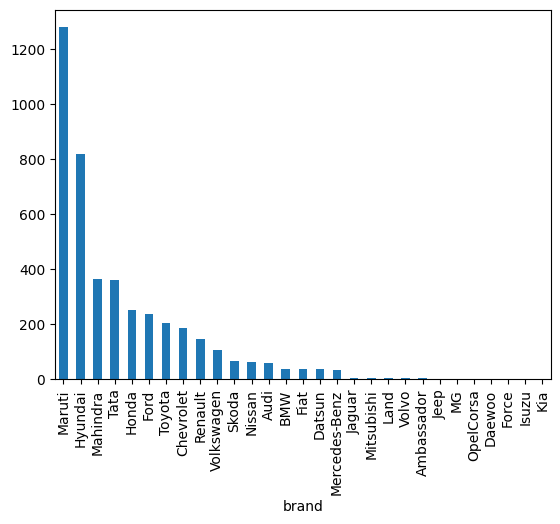

In [114]:
cars.brand.value_counts().plot(kind='bar')
plt.show()

## Data Preprocessing

### Data Cleaning

### Data Wrangling

## Feature engineering

In [ ]:
cars['brand'] = cars.name.str.split().str[0]

In [19]:
cars.drop('name', axis=1, inplace=True)

# 3. Model Building

# 4. Evaluation

# 5. Model Deployment

# 6. Monitoring and Maintenance 

# Resources

1. [Mind Map](https://360digitmg.com/mindmap/data-science)
2. [Kaggle information about dataset - Car Dekho](https://www.kaggle.com/datasets/akshaydattatraykhare/car-details-dataset)